## Create Graph Plots of the Vector Images in Tempest

In [1]:
!ffmpeg -i titles/titles.webm -pix_fmt rgba titles/frames/%04d.png

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [5]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def scvec(old_x,old_y,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def calvec(old_x,old_y,x,y,CALBRITE):
    vec=(x-old_x,y-old_y,CALBRITE)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def parse_calvec_parms(parms):
    x,y = [x.replace('.','') for x in parms[0].split(',')]
    x = 0x00 if x == "NXE" else int(x,16)
    y = int(y,16)
    return (x,y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "CNTR":
            vecs+=[(0,0,"BLACK")]
        elif cmd == "CSTAT":
            color = parms[0]
        elif cmd == "VCTR":
            parms = parms[0].split(',')
            vecs+=[vctr(color,*parms)]
        elif cmd == "VEC":
            # A 0,0 origin is implicit.
            if len(vecs) == 0:
                vecs+=[(0,0,default_color)]    
            parms = parms[0].split(',')
            vecs+=[vctr(default_color,*parms)]
        elif cmd == "SCVEC":
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
        elif cmd == "VDOT":
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd in [".BRITE=VARBRT",".BRITE =VARBRT"]:
            CALBRITE=default_color
        elif cmd in [".BRITE=0",".BRITE =0"]:
            CALBRITE="BLACK"
        elif cmd == "CALVEC":
            x,y = parse_calvec_parms(parms)
            vec,old_x,old_y = calvec(old_x,old_y,x,y,CALBRITE)
            vecs+=[vec]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))

def plot_vertices(verts,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)

def plot_vertices_imgonly(verts,file_name,points="",linewidth=3.0):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha,linewidth=linewidth)
    plt.axis('off')
    plt.savefig(f"titles/vec_image_{file_name}.png", bbox_inches='tight')

def tabulateVecsAndVerts(vectors,vertices):
    data =[["Vector X", "Vector Y", "Vertex X", "Vertex Y"]]
    for (vx,vy,_),(x,y,_) in zip(vectors,vertices):
        data +=[[str(vx),str(vy),str(x),str(y),]]
    table = tabulate.tabulate(data, tablefmt='html')
    return table

## Images from ALVROM.MAC

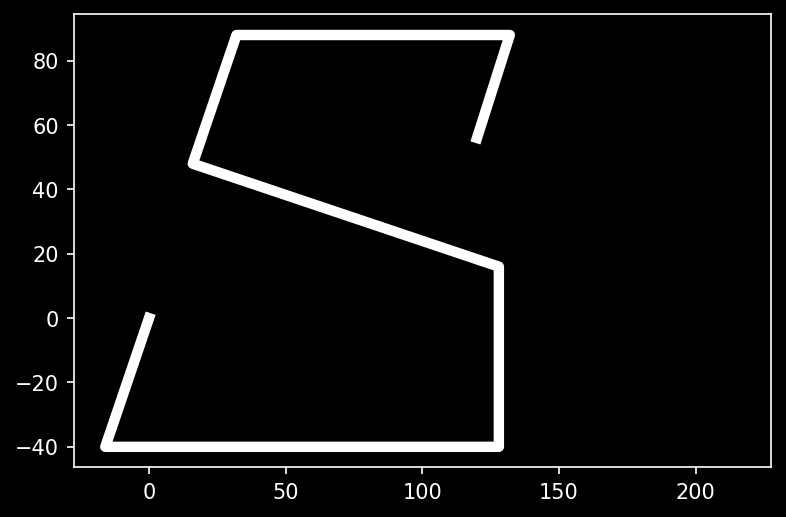

In [6]:
vector_data = """
TEMLIT:
	CNTR
S:	
    VCTR -10,-28,CB		;S
	VCTR 90,0,CB
	VCTR 0,38,CB
	VCTR -70,20,CB
	VCTR 10,28,CB
	VCTR 64,0,CB
	VCTR -0C,-20,CB
	RTSL
	VCTR 60,-60,0
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,linewidth=5)
plt.savefig(f"titles/letters/S.png", bbox_inches='tight')


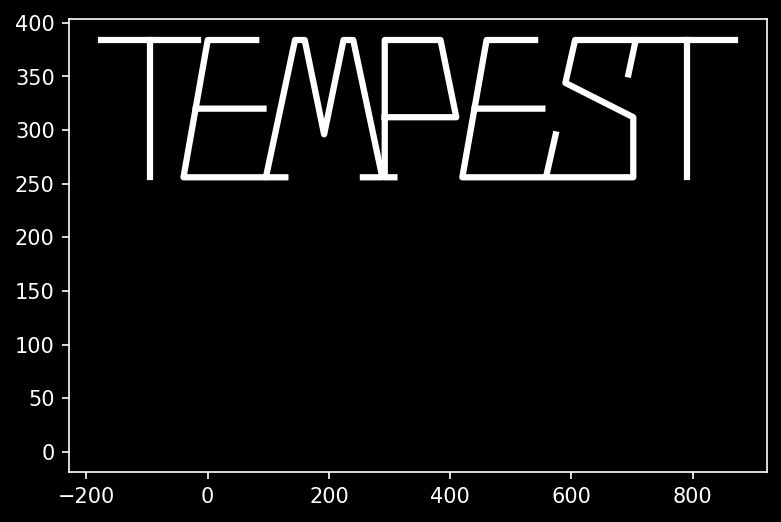

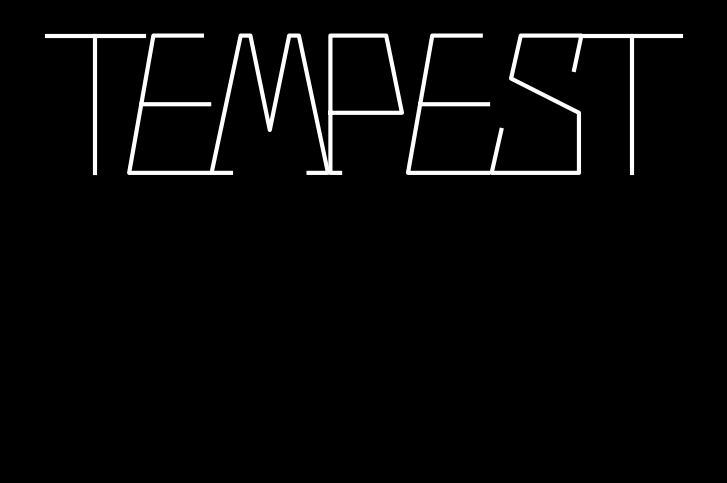

In [9]:
vector_data = """
TEMLIT:
	CNTR
	VCTR -60,100,0
T:	
    VCTR 0,80,CB		;T
	VCTR -50,0,0
	VCTR 0A0,0,CB
	RTSL
	VCTR 60,0,0
E:	
    VCTR -50,0,CB		;E
	VCTR -14,-40,CB
	VCTR 70,0,CB
	VCTR -70,0,0
	VCTR -14,-40,CB
	VCTR 84,0,CB
	RTSL
	VCTR 24,0,0
M:	
    VCTR -20,0,CB		;M
	VCTR 30,80,CB
	VCTR 10,0,CB
	VCTR 20,-58,CB
	VCTR 20,58,CB
	VCTR 10,0,CB
	VCTR 30,-80,CB
	VCTR -20,0,CB
	RTSL
	VCTR 34,0,0
P:	
    VCTR -10,0,CB		;P
	VCTR 0,80,CB
	VCTR 5C,0,CB
	VCTR 1A,-48,CB
	VCTR -76,0,CB
	RTSL
	VCTR 0F8,48,0
E:	
    VCTR -50,0,CB		;E
	VCTR -14,-40,CB
	VCTR 70,0,CB
	VCTR -70,0,0
	VCTR -14,-40,CB
	VCTR 84,0,CB
	RTSL
	VCTR 16,28,0
S:	
    VCTR -10,-28,CB		;S
	VCTR 90,0,CB
	VCTR 0,38,CB
	VCTR -70,20,CB
	VCTR 10,28,CB
	VCTR 64,0,CB
	VCTR -0C,-20,CB
	RTSL
	VCTR 60,-60,0
T:	
    VCTR 0,80,CB		;T
	VCTR -50,0,0
	VCTR 0A0,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)
plot_vertices_imgonly(vertices,"curs5",points="",linewidth=2.0)



In [34]:
0x02 << 3

16